In [1]:
# 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, zscore, probplot
import warnings
warnings.filterwarnings("ignore")

In [3]:
# ---Load Data ---
file_path = './wr_nfl_df_sorted_final.csv'  # Update if necessary
wr_df = pd.read_csv(file_path)

# --- 🔍 Initial Peek ---
print(f"Shape: {wr_df.shape}")
print("Columns:", wr_df.columns.tolist())
display(wr_df.head())

Shape: (17449, 118)
Columns: ['season', 'season_type', 'week', 'name', 'position', 'recent_team', 'fpts', 'dk_salary', 'fd_salary', 'rost', 'opponent_abbr', 'home', 'role', 'result', 'score', 'spread', 'over_under', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards', 'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share', 'wopr', 'player_display_name', 'team_abbr_x', 'avg_cushion', 'avg_separation', 'avg_intended_air_yards', 'percent_share_of_intended_air_yards', 'catch_percentage', 'yards', 'rec_touchdowns', 'avg_yac', 'avg_expected_yac', 'avg_yac_above_expectation', 'receiving_broken_tackles', 'receiving_drop', 'receiving_drop_pct', 'receiving_rat', 'g', 'rec', 'yds', 'ybc', 'air', 'yac', 'yacon', 'brktkl', 'tgt', 'catchable', 'drop', 'rz tgt', '10+ yds', '20+ yds', '30+ yds', '40+ yds', '50+ yds', 'rec_rz', 'tgt_rz', 

,season,season_type,week,name,position,recent_team,fpts,dk_salary,fd_salary,rost,...,rec_ge_7,target_share_ge_20,target_share_ge_30,over_100_yds,double_digit_targets,boom_week,bust_week,is_home_game,O_U,Total
0,2019,REG,1,A.J. Brown,WR,TEN,10.0,3500.0,5100.0,99.0%,...,0,0,0,1,0,0,0,1,over,44.0
1,2019,REG,2,A.J. Brown,WR,TEN,2.5,4000.0,5400.0,99.0%,...,0,0,0,0,0,0,1,0,under,43.5
2,2019,REG,3,A.J. Brown,WR,TEN,0.4,3700.0,5200.0,99.0%,...,0,0,0,0,0,0,1,1,under,38.0
3,2019,REG,4,A.J. Brown,WR,TEN,21.4,3700.0,4700.0,99.0%,...,0,0,0,0,0,1,0,1,under,46.0
4,2019,REG,5,A.J. Brown,WR,TEN,2.7,4200.0,5600.0,99.0%,...,0,0,0,0,0,0,1,0,under,39.5


In [4]:
def list_columns(df, n_per_row=4):
    cols = df.columns.tolist()
    for i in range(0, len(cols), n_per_row):
        print(", ".join(f"{col}" for col in cols[i:i+n_per_row]))
list_columns(wr_df)

season, season_type, week, name
position, recent_team, fpts, dk_salary
fd_salary, rost, opponent_abbr, home
role, result, score, spread
over_under, receptions, targets, receiving_yards
receiving_tds, receiving_fumbles, receiving_fumbles_lost, receiving_air_yards
receiving_yards_after_catch, receiving_first_downs, receiving_epa, receiving_2pt_conversions
racr, target_share, air_yards_share, wopr
player_display_name, team_abbr_x, avg_cushion, avg_separation
avg_intended_air_yards, percent_share_of_intended_air_yards, catch_percentage, yards
rec_touchdowns, avg_yac, avg_expected_yac, avg_yac_above_expectation
receiving_broken_tackles, receiving_drop, receiving_drop_pct, receiving_rat
g, rec, yds, ybc
air, yac, yacon, brktkl
tgt, catchable, drop, rz tgt
10+ yds, 20+ yds, 30+ yds, 40+ yds
50+ yds, rec_rz, tgt_rz, rec pct_rz
y/r_rz, tgt pct_rz, tgt_3wk_avg, tgt_5wk_avg
tgt_7wk_avg, tgt_lag_1, rec_3wk_avg, rec_5wk_avg
rec_7wk_avg, rec_lag_1, rec_yds_3wk_avg, rec_yds_5wk_avg
rec_yds_7wk_avg, r

In [5]:
def describe_dataframe(df):
    desc = df.describe(include='all').T
    desc['missing'] = df.isna().sum()
    desc['missing_pct'] = (desc['missing'] / len(df) * 100).round(2)
    desc['dtype'] = df.dtypes
    return desc

describe_dataframe(wr_df)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,missing,missing_pct,dtype
season,17449.0,NaN,NaN,NaN,2020.600607,2.276326,2017.0,2019.0,2021.0,2023.0,2024.0,0,0.00,int64
season_type,17449,2,REG,16686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.00,object
week,17449.0,NaN,NaN,NaN,9.735056,5.469949,1.0,5.0,10.0,14.0,22.0,0,0.00,int64
name,17449,565,Tyreek Hill,140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.00,object
position,17449,1,WR,17449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.00,object
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
boom_week,17449.0,NaN,NaN,NaN,0.02705,0.162235,0.0,0.0,0.0,0.0,1.0,0,0.00,int64
bust_week,17449.0,NaN,NaN,NaN,0.571379,0.494893,0.0,0.0,1.0,1.0,1.0,0,0.00,int64
is_home_game,17449.0,NaN,NaN,NaN,0.500143,0.500014,0.0,0.0,1.0,1.0,1.0,0,0.00,int64
O_U,17266,2,under,8912,NaN,NaN,NaN,NaN,NaN,NaN,NaN,183,1.05,object


In [6]:
# Begin Macro-level league-wide analysis

In [7]:
def add_macro_features(df):
    df = df.copy()

    # --- Normalize DK/FD Salary by Season ---
    df['dk_salary_norm'] = df.groupby('season')['dk_salary'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min())
    )
    df['fd_salary_norm'] = df.groupby('season')['fd_salary'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min())
    )

    # --- Log + Sqrt Transformations ---
    df['log_fpts'] = np.log1p(df['fpts'].clip(lower=0))
    df['log_receiving_yards'] = np.log1p(df['receiving_yards'].clip(lower=0))
    df['log_receiving_yards_after_catch'] = np.log1p(df['receiving_yards_after_catch'].clip(lower=0))
    df['sqrt_targets'] = np.sqrt(df['targets'].clip(lower=0))
    df['sqrt_receptions'] = np.sqrt(df['receptions'].clip(lower=0))

    # --- Value Over Cost ---
    df['value_ratio'] = df['fpts'] / (df['dk_salary'] / 1000)

    # --- WR1/WR2 Tier Flag ---
    df['is_high_tier_wr'] = (df['targets'] >= 6) | (df['dk_salary'] >= 6000)

    return df


In [8]:
# Apply macro-level features
wr_df_macro = add_macro_features(wr_df)

# Inspect column structure
list_columns(wr_df_macro)

season, season_type, week, name
position, recent_team, fpts, dk_salary
fd_salary, rost, opponent_abbr, home
role, result, score, spread
over_under, receptions, targets, receiving_yards
receiving_tds, receiving_fumbles, receiving_fumbles_lost, receiving_air_yards
receiving_yards_after_catch, receiving_first_downs, receiving_epa, receiving_2pt_conversions
racr, target_share, air_yards_share, wopr
player_display_name, team_abbr_x, avg_cushion, avg_separation
avg_intended_air_yards, percent_share_of_intended_air_yards, catch_percentage, yards
rec_touchdowns, avg_yac, avg_expected_yac, avg_yac_above_expectation
receiving_broken_tackles, receiving_drop, receiving_drop_pct, receiving_rat
g, rec, yds, ybc
air, yac, yacon, brktkl
tgt, catchable, drop, rz tgt
10+ yds, 20+ yds, 30+ yds, 40+ yds
50+ yds, rec_rz, tgt_rz, rec pct_rz
y/r_rz, tgt pct_rz, tgt_3wk_avg, tgt_5wk_avg
tgt_7wk_avg, tgt_lag_1, rec_3wk_avg, rec_5wk_avg
rec_7wk_avg, rec_lag_1, rec_yds_3wk_avg, rec_yds_5wk_avg
rec_yds_7wk_avg, r

In [9]:
# Plots the trend of a single stat column grouped by a column (e.g., season).

"""
Parameters:
- df: DataFrame
- group_col: str, e.g., 'season'
- stat_col: str, e.g., 'fpts'
- agg_func: str, default is 'mean'
- figsize: tuple
"""

def plot_single_stat_trend(df, group_col, stat_col, agg_func='mean', figsize=(10, 5)):

    grouped = df.groupby(group_col)[stat_col].agg(agg_func)
    
    plt.figure(figsize=figsize)
    plt.plot(grouped.index, grouped.values, marker='o', linestyle='-', color='tab:blue')
    plt.title(f"{agg_func.title()} of {stat_col} by {group_col}")
    plt.xlabel(group_col.title())
    plt.ylabel(f"{agg_func.title()} {stat_col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


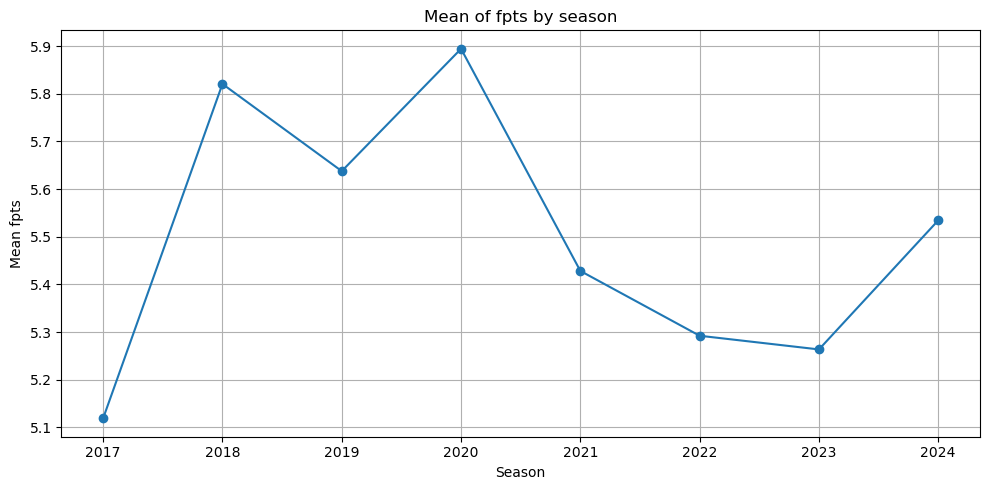

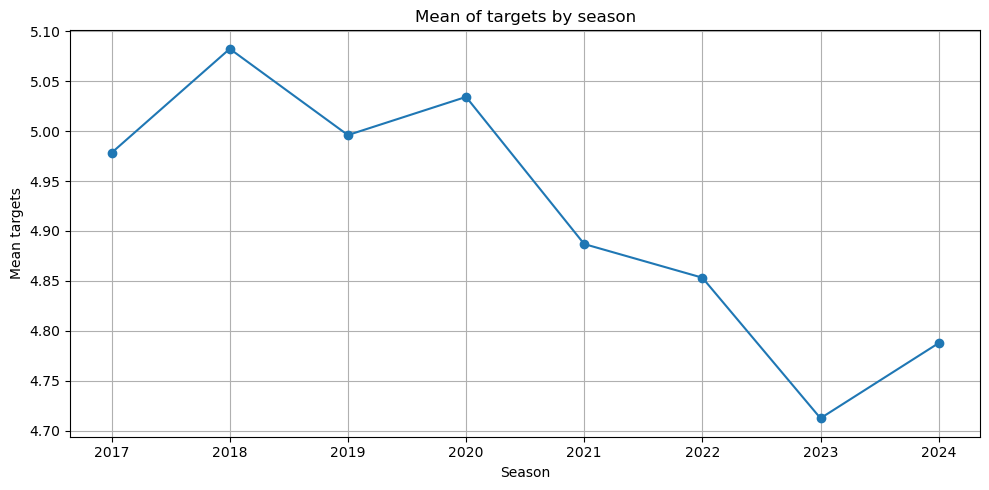

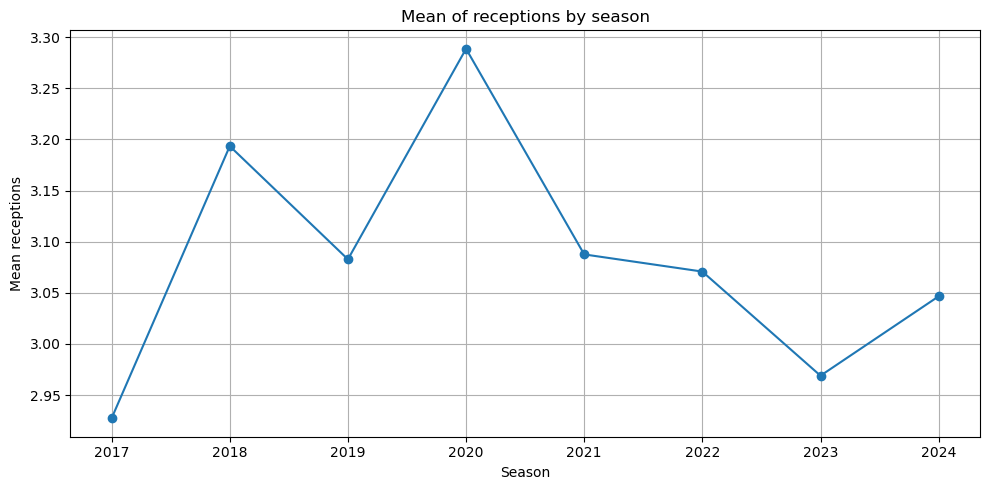

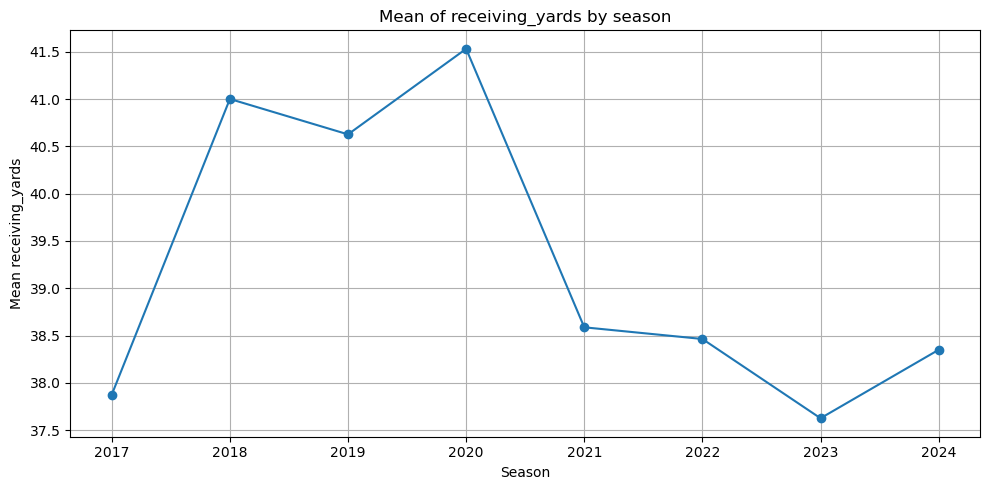

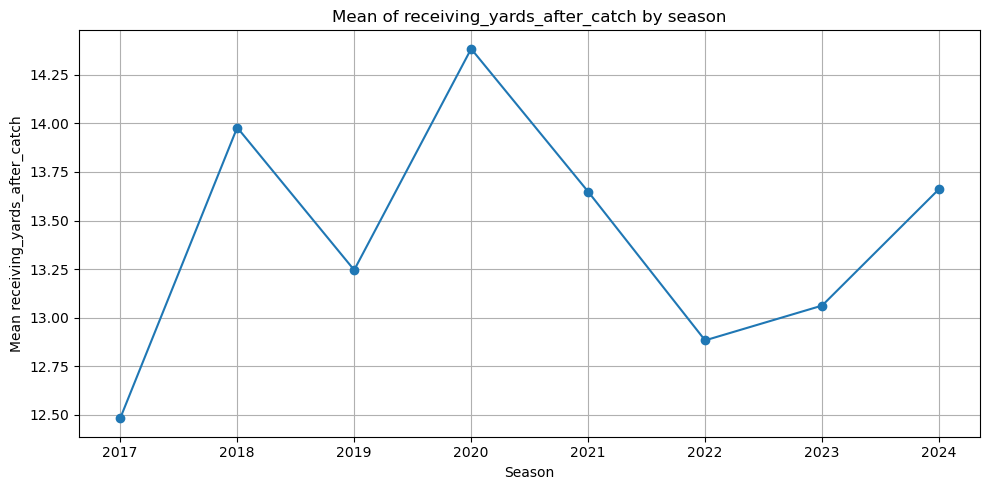

In [10]:
## Input required - select columns
for stat in ['fpts', 'targets', 'receptions', 'receiving_yards', 'receiving_yards_after_catch']:
    plot_single_stat_trend(wr_df, group_col='season', stat_col=stat)


In [11]:
def plot_histogram(df, col, bins=40, figsize=(8, 5), color='royalblue'):
    """
    Plots a histogram for a single stat column.
    
    Parameters:
    - df: DataFrame
    - col: column to plot
    - bins: number of bins
    - figsize: size of the plot
    - color: bar color
    """
    plt.figure(figsize=figsize)
    plt.hist(df[col].dropna(), bins=bins, color=color, edgecolor='black')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


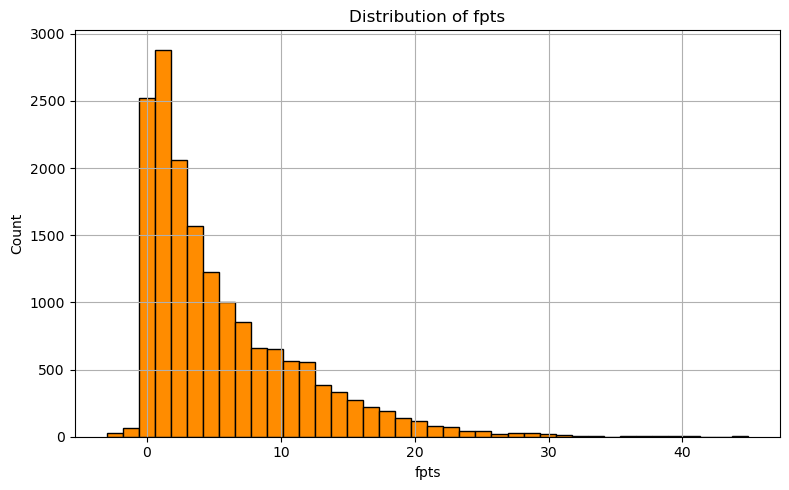

In [12]:
plot_histogram(wr_df, 'fpts', color='darkorange')

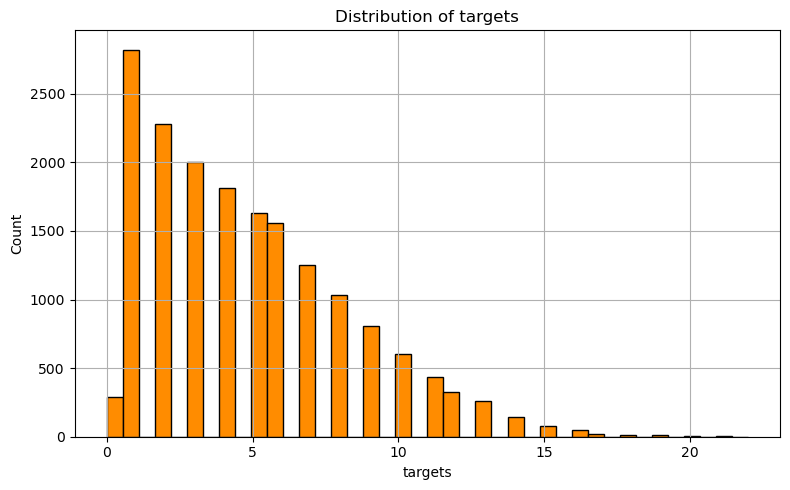

In [13]:
plot_histogram(wr_df, 'targets', color='darkorange')


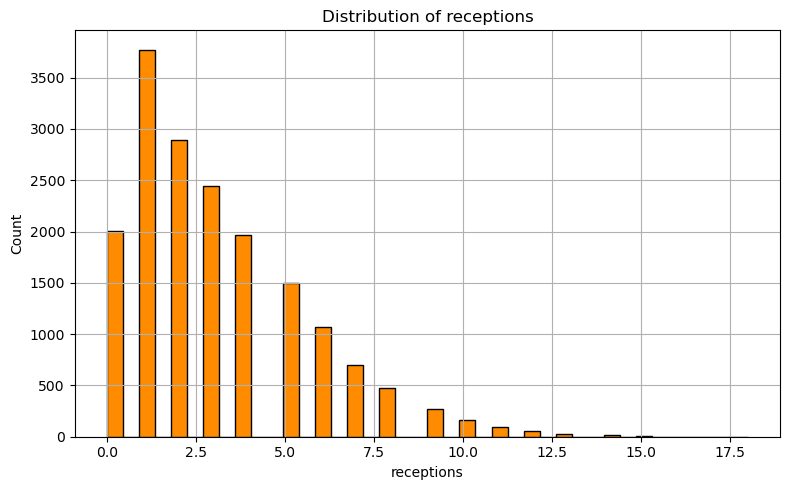

In [14]:
plot_histogram(wr_df, 'receptions', color='darkorange')


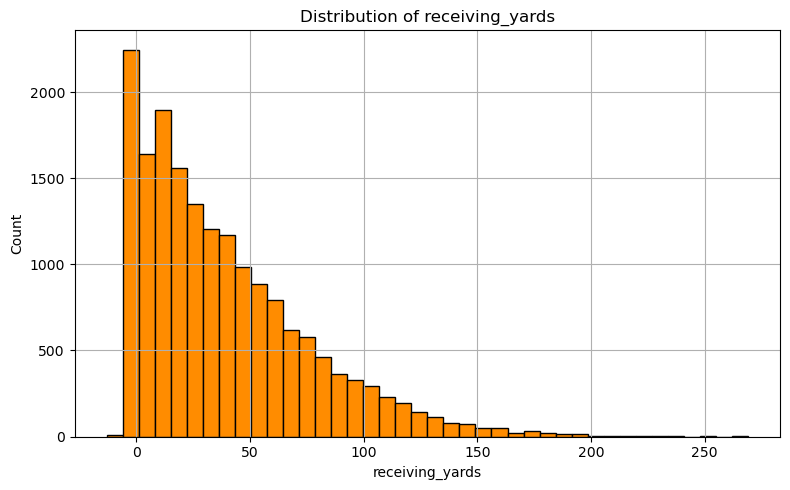

In [15]:
plot_histogram(wr_df, 'receiving_yards', color='darkorange')


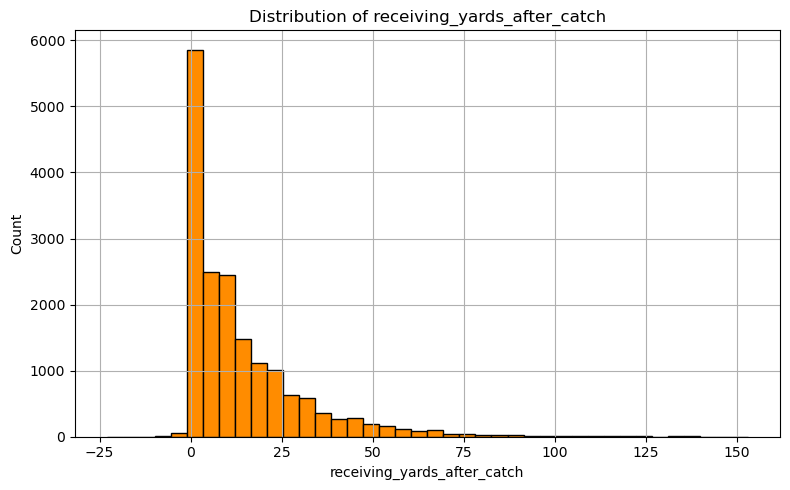

In [16]:
plot_histogram(wr_df, 'receiving_yards_after_catch', color='darkorange')

In [17]:
def plot_multiple_histograms(df, cols, bins=40, cols_per_row=2, figsize_per_plot=(6, 4), color='teal'):
    """
    Improved layout for multiple histograms with flexible row/col sizing.
    """
    num_plots = len(cols)
    rows = (num_plots + cols_per_row - 1) // cols_per_row
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(figsize_per_plot[0] * cols_per_row, figsize_per_plot[1] * rows))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        if col not in df.columns:
            print(f"⚠️ Skipping missing column: {col}")
            continue
        axes[i].hist(df[col].dropna(), bins=bins, color=color, edgecolor='black')
        axes[i].set_title(f"{col}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Count")
        axes[i].grid(True)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


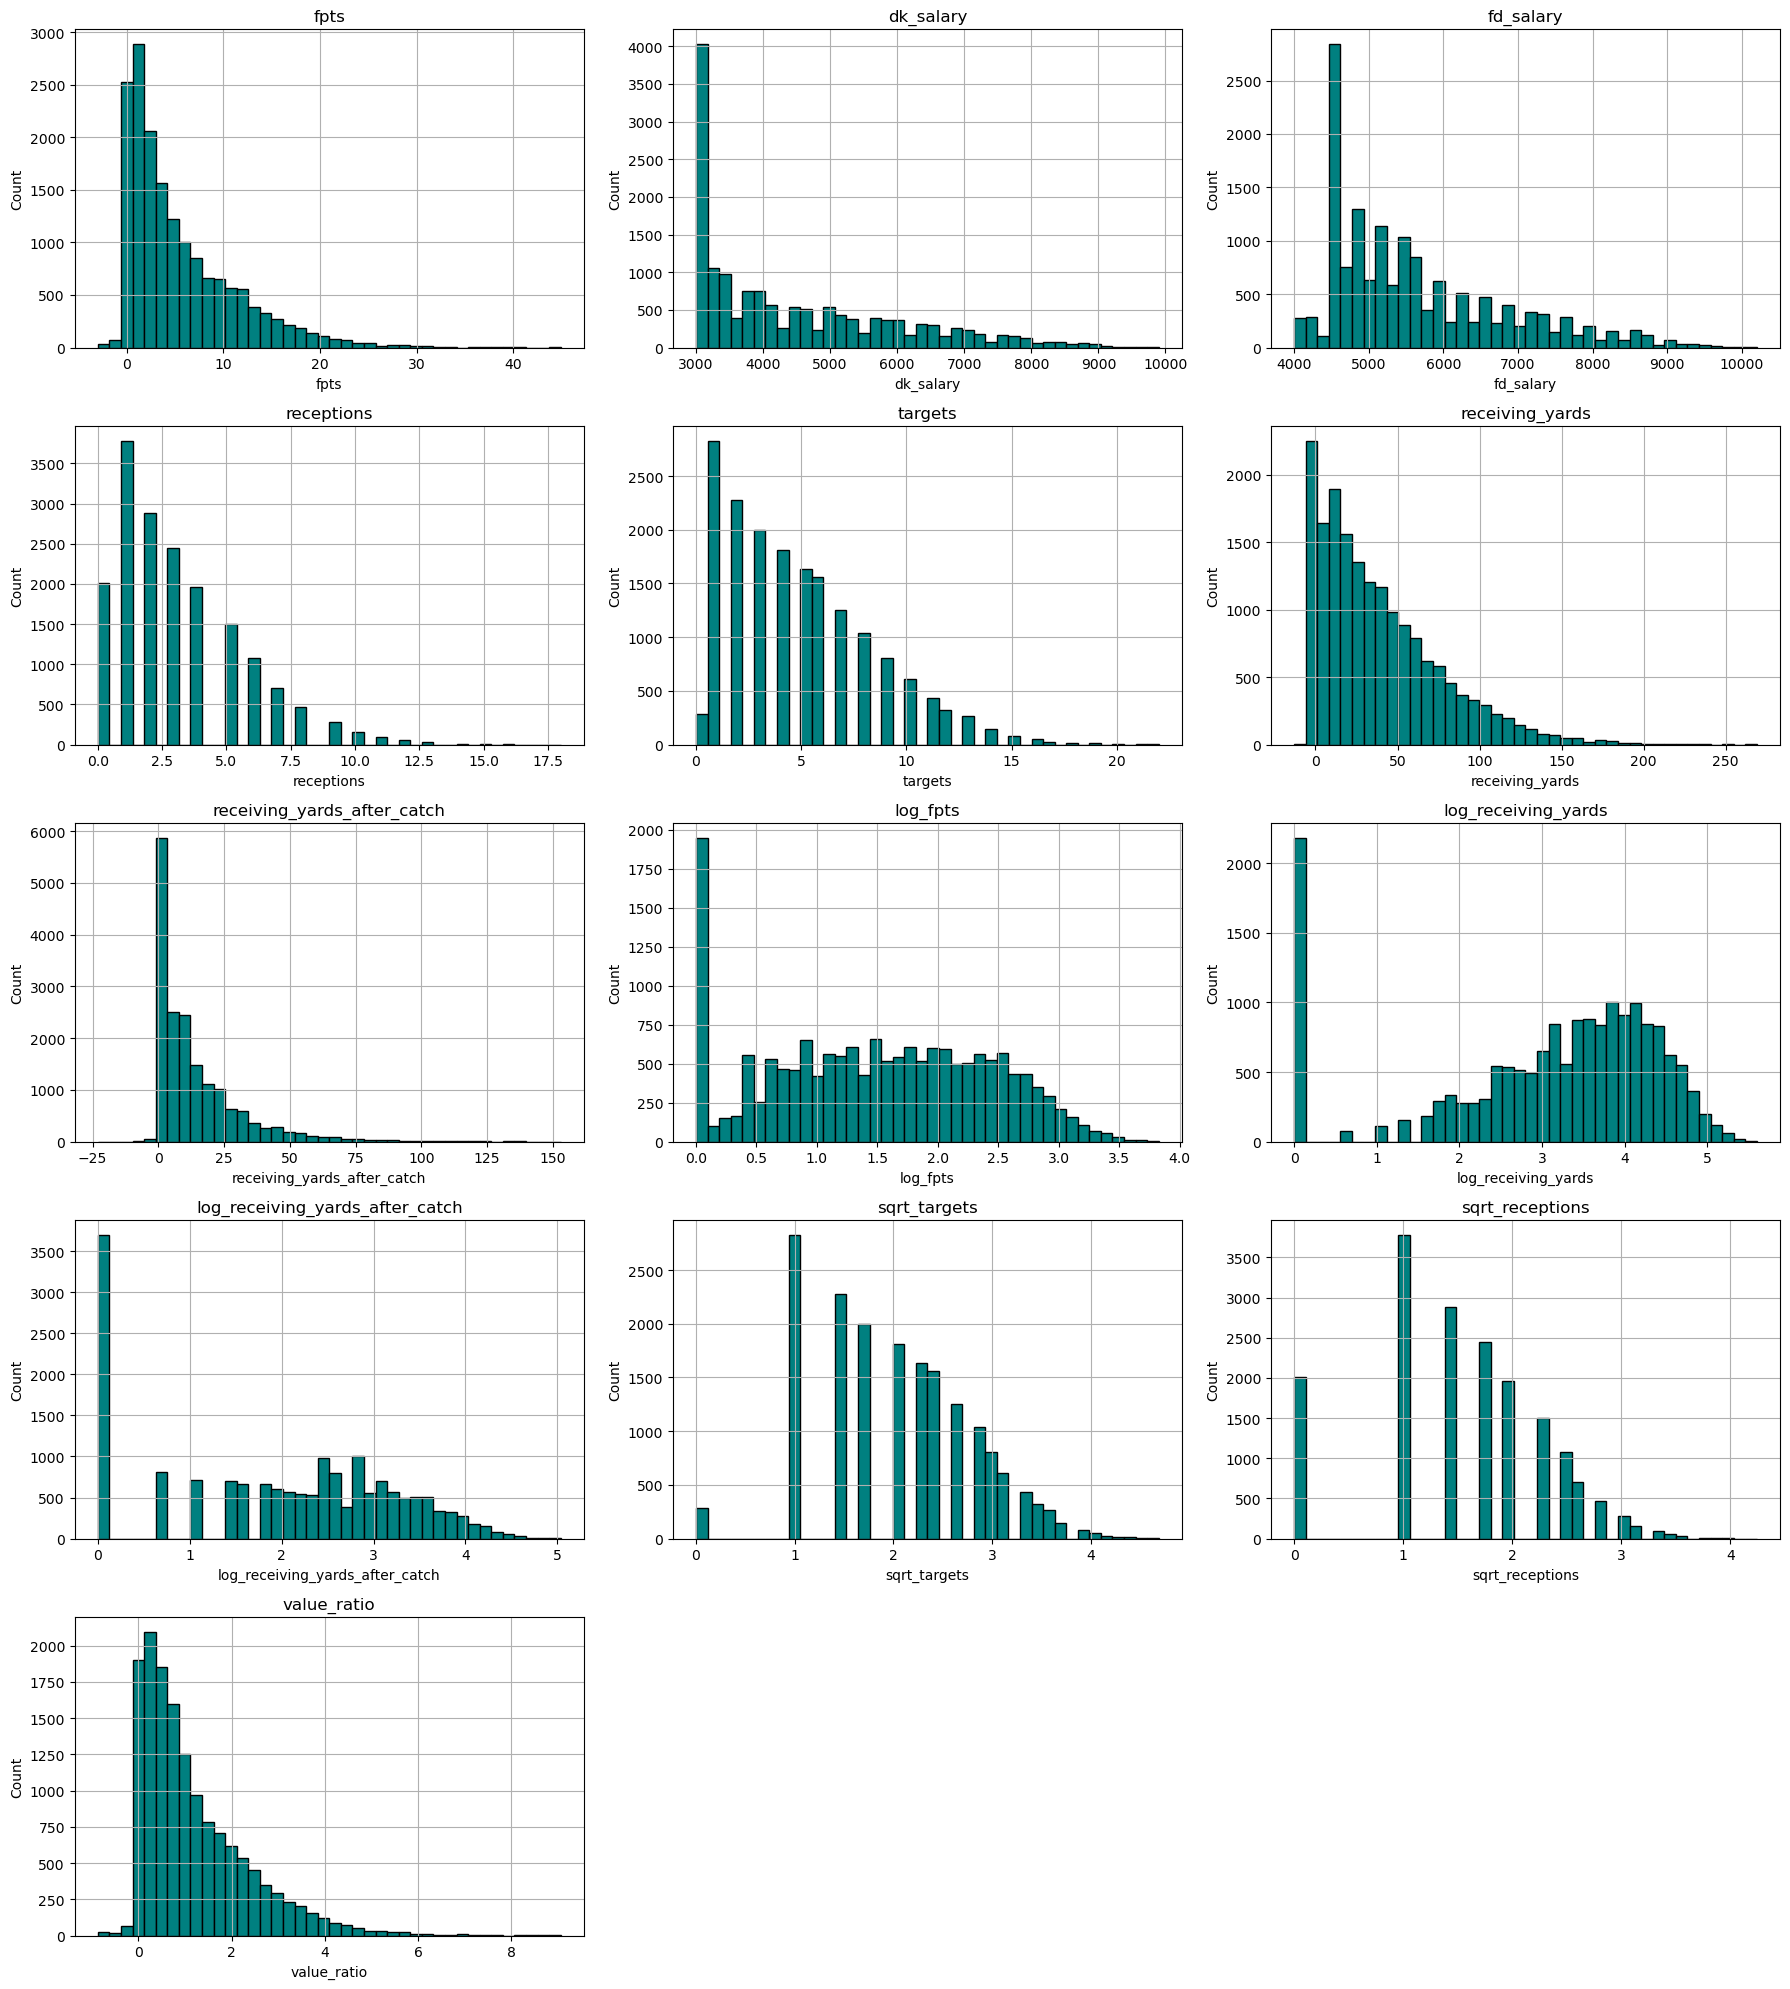

In [18]:
# Macro-level visual summary
macro_cols_to_plot = [
    'fpts', 'dk_salary', 'fd_salary',
    'receptions', 'targets', 'receiving_yards',
    'receiving_yards_after_catch', 'log_fpts', 
    'log_receiving_yards', 'log_receiving_yards_after_catch',
    'sqrt_targets', 'sqrt_receptions', 'value_ratio'
]

plot_multiple_histograms(wr_df_macro, macro_cols_to_plot, cols_per_row=3)


In [19]:
def plot_qq(df, col, figsize=(6, 6)):
    """
    Generates a QQ plot for a given column to assess normality.
    """
    plt.figure(figsize=figsize)
    probplot(df[col].dropna(), dist="norm", plot=plt)
    plt.title(f"QQ Plot for {col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [20]:
def shapiro_test(df, col):
    """
    Performs Shapiro-Wilk test on a column.
    Returns W-statistic and p-value.
    """
    data = df[col].dropna()
    if len(data) > 5000:
        data = data.sample(5000, random_state=42)
    stat, p = shapiro(data)
    print(f"Shapiro-Wilk Test for {col}: W = {stat:.4f}, p = {p:.4e}")
    return stat, p


In [21]:
def qq_and_shapiro_side_by_side(df, col, figsize=(10, 5)):
    """
    Displays QQ plot and Shapiro-Wilk p-value side by side.
    """
    data = df[col].dropna()
    if len(data) > 5000:
        data = data.sample(5000, random_state=42)

    # Shapiro test
    stat, p = shapiro(data)

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    probplot(data, dist="norm", plot=ax)
    ax.set_title(f"QQ Plot for {col}\nShapiro-Wilk: W={stat:.4f}, p={p:.4e}")
    ax.grid(True)
    plt.tight_layout()
    plt.show()


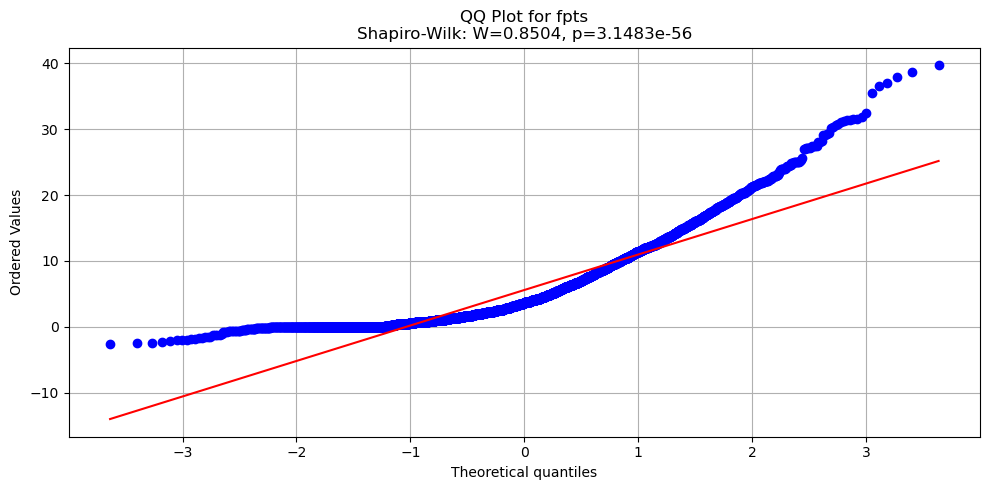

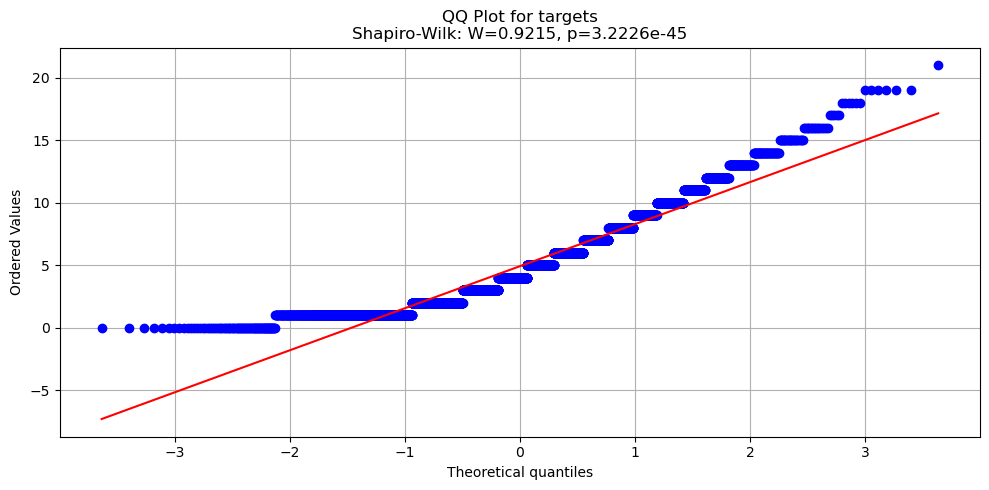

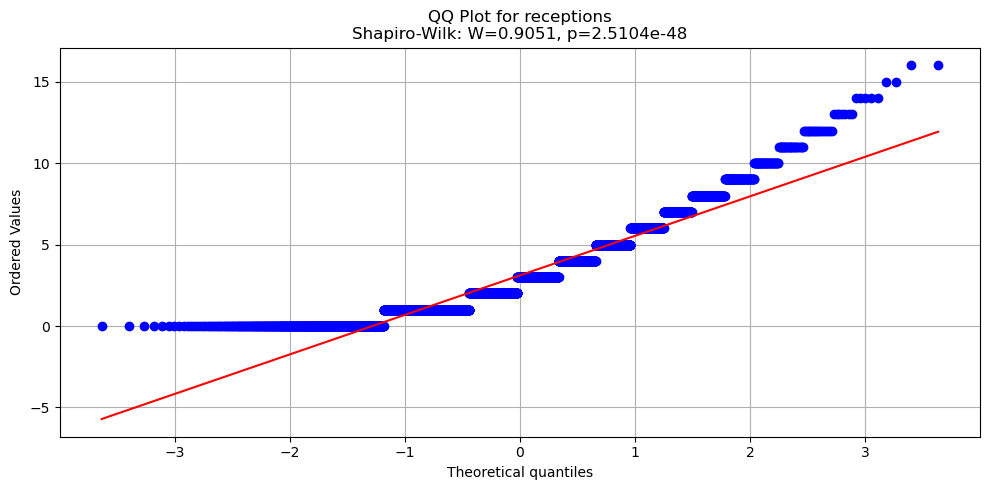

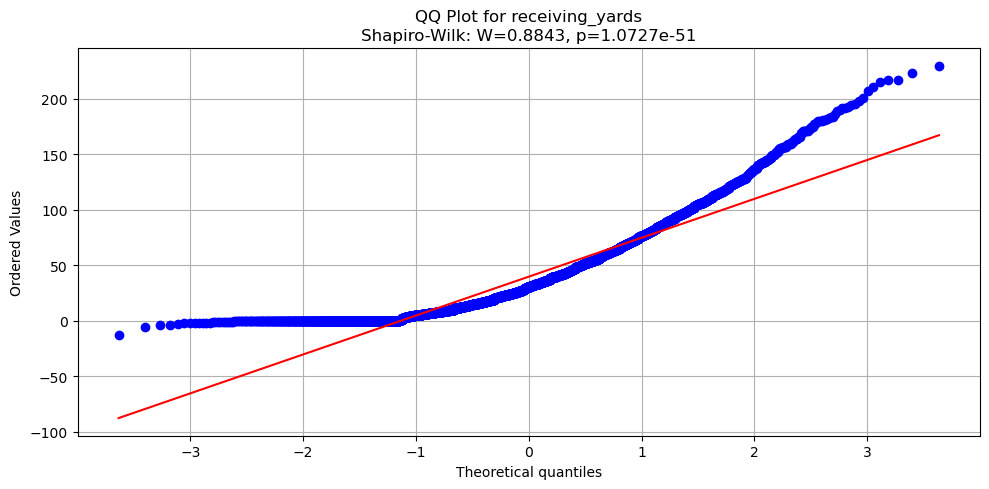

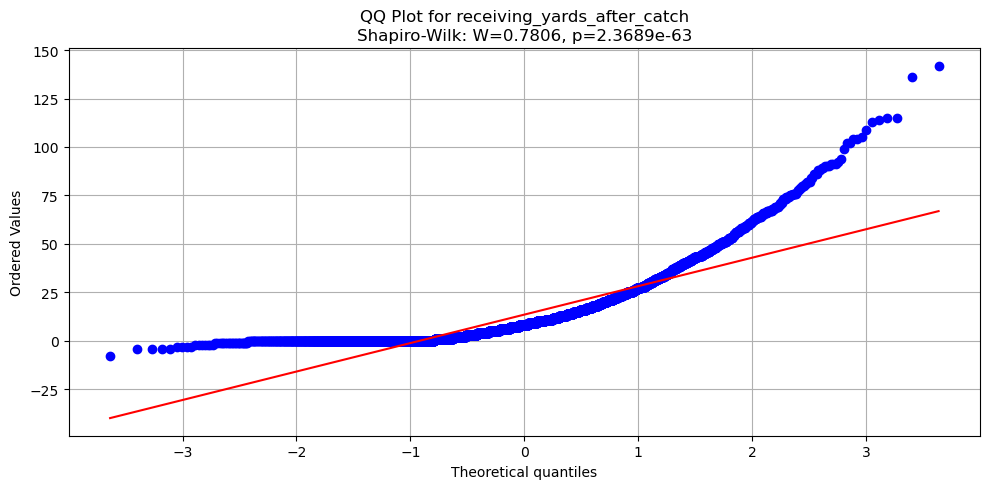

In [22]:
for feature in ['fpts', 'targets', 'receptions', 'receiving_yards', 'receiving_yards_after_catch']:
    qq_and_shapiro_side_by_side(wr_df_macro, feature)


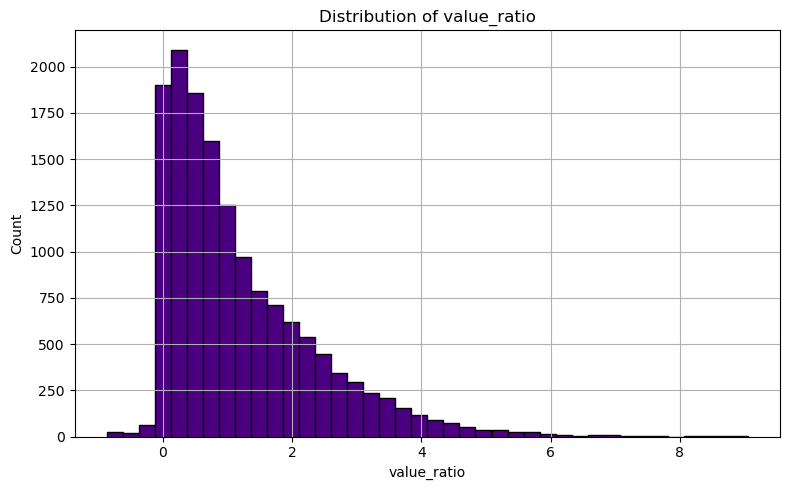

In [23]:
plot_histogram(wr_df_macro, 'value_ratio', bins=40, color='indigo')


In [24]:
def plot_value_vs_salary(df):
    plt.figure(figsize=(10, 6))
    plt.scatter(df['dk_salary'], df['value_ratio'], alpha=0.4, color='crimson')
    plt.title('Value Ratio vs. DK Salary')
    plt.xlabel('DK Salary')
    plt.ylabel('Value Ratio (fpts per $1000)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


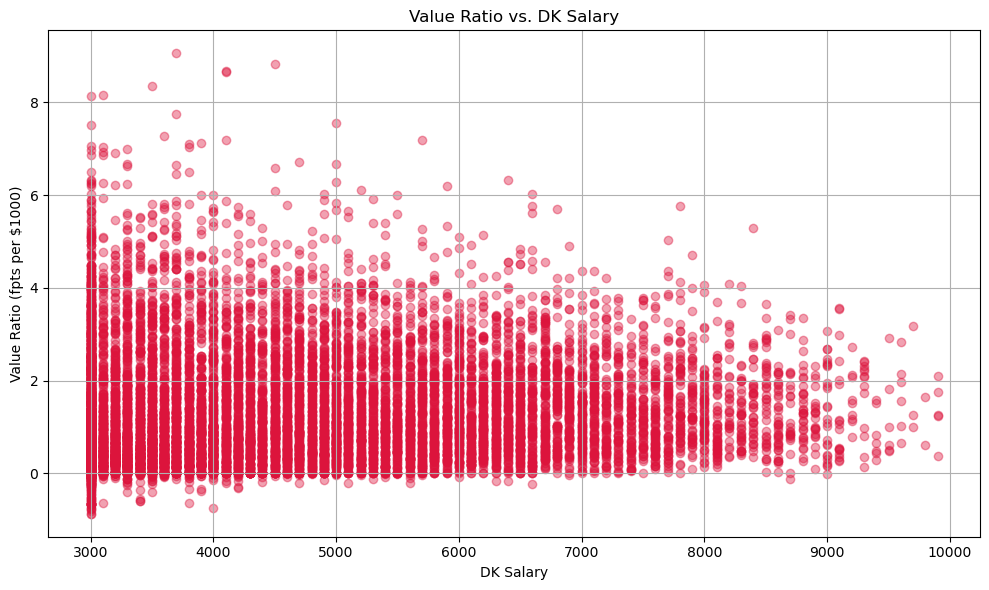

In [25]:
plot_value_vs_salary(wr_df_macro)


In [100]:
# --- 📋 Macro-Level Summary Output ---
print("🔍 MACRO ANALYSIS SUMMARY")
print("-" * 60)
print(f"Total Rows: {wr_df_macro.shape[0]}")
print(f"Total Columns: {wr_df_macro.shape[1]}")
print()

print("✅ Key Insights:")
print("• Most core features are right-skewed (fpts, yards, receptions, etc.)")
print("• Applied log/sqrt transforms to address skewness:")
print("   - log_fpts, log_receiving_yards, sqrt_targets, etc.")
print("• Created 'value_ratio' = fpts / (dk_salary / 1000) to quantify ROI.")
print("• Defined 'is_high_tier_wr' for WR1/WR2 based on targets and salary.")
print("• Shapiro-Wilk and QQ plots confirm non-normality → RF or tree-based models suitable.")
print()
print("📁 Exporting updated dataframe with macro-level features...")

# Save updated dataframe
wr_df_macro.to_csv('wr_macro_stats_df.csv', index=False)

print("✅ File saved as 'wr_macro_stats_df.csv'")


🔍 MACRO ANALYSIS SUMMARY
------------------------------------------------------------
Total Rows: 17449
Total Columns: 127

✅ Key Insights:
• Most core features are right-skewed (fpts, yards, receptions, etc.)
• Applied log/sqrt transforms to address skewness:
   - log_fpts, log_receiving_yards, sqrt_targets, etc.
• Created 'value_ratio' = fpts / (dk_salary / 1000) to quantify ROI.
• Defined 'is_high_tier_wr' for WR1/WR2 based on targets and salary.
• Shapiro-Wilk and QQ plots confirm non-normality → RF or tree-based models suitable.

📁 Exporting updated dataframe with macro-level features...
✅ File saved as 'wr_macro_stats_df.csv'


In [26]:
# End Macro-level league-wide analysis

In [ ]:
# Begin: Micro-Level (Player-Specific Over Time)

In [31]:
# End: Micro-Level (Player-Specific Over Time)